In [1]:
import numpy as np
import cvxpy as cp
import scipy as sc
import math as ms
import matplotlib.pyplot as plt

from numpy import inf, linalg
from sklearn import linear_model
from scipy import optimize, sparse

In [2]:
from sklearn.utils import check_X_y # bookmark - missing data coding - Python - sklearn
from sklearn.utils import check_consistent_length # bookmark - missing data coding - Python - sklearn
from sklearn.utils import axis0_safe_slice # meaning?
from sklearn.utils.extmath import safe_sparse_dot # Dot product that handle the sparse matrix case correctly.

In [3]:
#data generating function
# m = mean, s = standard deviation, d = dimension, N = obs, T = # of training data set, q = probability of drawing a sample
# from outlying distribution, b = beta
def dgp(s, d, N, T, rho, b, btype = 'dense'):
    np.random.seed(100)
    mean = np.zeros(d) # mean 
    omega = np.full((d,d), rho) # d x d matrix with rho for all the elements
    omega[np.diag_indices_from(omega)] = 1 # change diagonal elements to 1, keeping the off-diagonal elements to rho
    
    # generating X_true
    X_true = np.random.multivariate_normal(mean,omega,(N,T))
    # changing the first column to 1
    X_true[:,:,0] = 1
    # constructing Y_true
    Y_true = np.zeros((N,T))
    for i in range(N):
        for j in range(T):
            Y_true[i,j] = np.random.normal(X_true[i,j,:] @ b, s) 
            
    # outlier distribution for both X and Y
    if btype == 'dense': 
        X_outlier1 = np.random.multivariate_normal(mean,omega,(N,T)) + np.random.multivariate_normal(np.multiply(5,np.ones(d)), np.identity(d))
        X_outlier1[:,:,0] = 1
        Y_outlier1 = np.zeros((N,T))
        for i in range(N):
            for j in range(T):
                Y_outlier1[i,j] = np.random.normal(X_outlier1[i,j,:] @ b, s)+ 5*s
                
    if btype == 'sparse':
        X_outlier2 = np.random.multivariate_normal(mean,omega,(N,T)) + np.random.multivariate_normal(np.zeros(d), 0.25*np.identity(d))
        X_outlier2[:,:,0] = 1
        Y_outlier2 = np.zeros((N,T))
        for i in range(N):
            for j in range(T):
                Y_outlier2[i,j] = np.random.normal(X_outlier2[i,j,:] @ b, s)+ 5*s

                
    # construction of contaminated data
    q = np.random.uniform(0,1,1)
    q = float(q)
    if q > 0.3:
        q = 0.3
    else: 
        q = q
    
    # observation selection in data 
    
    X_data = np.zeros((N,T,d))
    Y_data = np.zeros((N,T))
    for j in range(T):
        idx = np.random.choice(2, N, replace = True, p = [1-q, q])
        idx1 = np.where(idx == 0)
        idx2 = np.where(idx == 1)
        
        X_data[idx1,j,:] = X_true[idx1,j,:]
        Y_data[idx1,j] = Y_true[idx1,j]
        if btype == 'dense':
            X_data[idx2,j,:] = X_outlier1[idx2,j,:]
            Y_data[idx2,j] = Y_outlier1[idx2,j]
        if btype == 'sparse':
            X_data[idx2,j,:] = X_outlier2[idx2,j,:]
            Y_data[idx2,j] = Y_outlier2[idx2,j]
    
    # division of data into training and validation
    

    s0 = np.arange(N)
    s1 = np.random.choice(range(X_data.shape[0]), 100, replace = False)
    s2 = np.delete(s0,s1)
        
    X_train = X_data[s1,:,:]
    X_valid = X_data[s2,:,:]
    Y_train = Y_data[s1,:]
    Y_valid = Y_data[s2,:]
        
    return X_train, Y_train, X_valid, Y_valid, X_true, Y_true, omega, q
    


In [4]:
# s = standard deviation, d = dimension, N = obs, T = # of training data set, q = probability of drawing a sample
# from outlying distribution, b = beta
s = 3.8
d = 21
N = 125
T = 10
rho = 0.0
rho_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# dense case
b1 = np.full(d,0.5)
b1[0]=0.3

# sparse case
b2 = np.full(d,0.0)
b2[0] = 3
b2[1] = 0.05
b2[3] = 0.006
b2[5] = -0.007
b2[7] = 0.008

#print(b1)
#print(b2)

In [5]:
class reg_class:
    
    def w_l1(self, weights, X, y, alpha): #, tau):
        #t = tau
        w = weights

        beta = np.concatenate([np.array([[1]]),np.reshape(w,[-1,1]).T], axis=1)

        yp = safe_sparse_dot(X,w)
        diff = y - yp

        loss = np.sum(np.abs(diff))+ alpha*np.linalg.norm(beta,1)
        #loss = np.sum(np.where(diff<0, (t-1)*diff, t*diff)) + alpha*np.sum(abs(beta))
        
        return loss
    
    def wasserstein(self, X, y, lmda1, lmda2):
        import cvxpy as cp
        import cvxopt
    
        obv, feat = X.shape # dimension
        y1 = np.reshape(y,[-1,1]) # y converted to (N,1)
        beta = cp.Variable((feat,1)) # variable dimension to (d,1)

        a = np.array([[1]]) 
        c = cp.vstack([a,-beta]) # adding 1 in front of variables of interest
        l = cp.reshape(c,[1+feat,]) # reshaping the above into a list with no column 
        objective1 = cp.norm(y1 - (X@beta), 1)/obv + lmda1*cp.norm(l, 1)+ lmda2*cp.norm(l,2) 
        # This is the part that keeps me providing the same result when using Wasserstein \infty 
        # as when using Wasserstein 2.
        obj_func= cp.Problem(cp.Minimize(objective1))
        obj_func.solve()
            
                
        if obj_func.status == cp.OPTIMAL or obj_func.status == cp.OPTIMAL_INACCURATE:
            return np.array(beta.value)
        
    def lad(self, X, y, lmda1, lmda2): #, tau):
        import cvxpy as cp
        import cvxopt
    
        obv, feat = X.shape
        y1 = np.reshape(y,[-1,1])
        beta = cp.Variable((feat,1))
    
        
        objective1 = cp.norm(y1 - (X@beta), 1)/obv + lmda1*cp.norm(beta, 1)+ lmda2*cp.norm(beta,2) # typical regularization
        obj_func= cp.Problem(cp.Minimize(objective1))
        obj_func.solve()
                
        if obj_func.status == cp.OPTIMAL or obj_func.status == cp.OPTIMAL_INACCURATE:
            return np.array(beta.value)
    
    def fit(self, X,y, alpha = 0.0):#, tau = 0.0):
        #initw = np.random.multivariate_normal(np.zeros(X.shape[1]),np.identity(X.shape[1])) #initial weight
        initw = np.random.rand(X.shape[1])
        value_l1_reg = optimize.minimize(self.l1_regular, initw, args = (X,y,alpha),method = "Nelder-Mead") #,tau), method = "BFGS")
        value_w_l1 = optimize.minimize(self.w_l1, initw, args = (X,y,alpha),method = "Nelder-Mead")
        
        return value_w_l1, value_l1_reg

In [6]:
if __name__ == '__main__':
    model = reg_class()
    #np.set_printoptions(suppress=True)
    MSE_w_l1 = np.zeros((len(rho_range),T))
    MSE_w_l2 = np.zeros((len(rho_range),T))
    MSE_l1_reg = np.zeros((len(rho_range),T))
    MSE_l2_reg = np.zeros((len(rho_range),T))
    beta_collection_w_l1 = np.zeros([d,len(rho_range),T])
    beta_collection_w_l2 = np.zeros([d,len(rho_range),T])
    beta_collection_l1_reg = np.zeros([d,len(rho_range),T])
    beta_collection_l2_reg = np.zeros([d,len(rho_range),T])
    #dense
    for i in range(len(rho_range)):
        X_train, Y_train, X_valid, Y_valid, X_true, Y_true, omega, _ = dgp(s, d, N, T, rho_range[i], b1, btype = 'dense')
        
        for j in range(T):
            #w_l1, l1_reg = model.fit(X_train[:,j,:], Y_train[:,j], alpha = 1)
            result1 = model.wasserstein(X_train[:,j,:],Y_train[:,j], lmda1 = 3, lmda2 = 0.0)
            result2 = model.wasserstein(X_train[:,j,:],Y_train[:,j], lmda1 = 0.0, lmda2 = 0.0)
            result3 = model.lad(X_train[:,j,:],Y_train[:,j], lmda1 = 3, lmda2 = 0.0)
            result4 = model.lad(X_train[:,j,:],Y_train[:,j], lmda1 = 0.0, lmda2 = 3.0)
            for k in range(len(result2)):
                beta_collection_w_l1[k,i,j] = result1[k]
                beta_collection_w_l2[k,i,j] = result2[k]
                beta_collection_l1_reg[k,i,j] = result3[k]
                beta_collection_l2_reg[k,i,j] = result4[k]
            MSE_w_l1[i,j] = np.sum((Y_true[:,j] - X_true[:,j,:] @ beta_collection_w_l1[:,i,j])**2)/len(Y_true[:,0])
            MSE_w_l2[i,j] = np.sum((Y_true[:,j] - X_true[:,j,:] @ beta_collection_w_l2[:,i,j])**2)/len(Y_true[:,0])
            MSE_l1_reg[i,j] = np.sum((Y_true[:,j] - X_true[:,j,:] @ beta_collection_l1_reg[:,i,j])**2)/len(Y_true[:,0])
            MSE_l2_reg[i,j] = np.sum((Y_true[:,j] - X_true[:,j,:] @ beta_collection_l2_reg[:,i,j])**2)/len(Y_true[:,0])

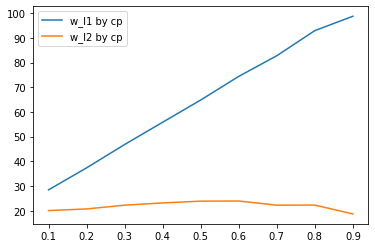

In [7]:
meanMSE_w_l1 = np.zeros(len(rho_range))
meanMSE_w_l2 = np.zeros(len(rho_range))
meanMSE_l1_reg = np.zeros(len(rho_range))
meanMSE_l2_reg = np.zeros(len(rho_range))
for k in range(len(rho_range)):
    meanMSE_w_l1[k] = 1/T*np.sum(MSE_w_l1[k,:])
    meanMSE_w_l2[k] = 1/T*np.sum(MSE_w_l2[k,:])
    meanMSE_l1_reg[k] = 1/T*np.sum(MSE_l1_reg[k,:])
    meanMSE_l2_reg[k] = 1/T*np.sum(MSE_l2_reg[k,:])
plt.figure()
plt.plot(rho_range,meanMSE_w_l1, label = 'w_l1 by cp')
plt.plot(rho_range,meanMSE_w_l2, label = 'w_l2 by cp')
#plt.plot(rho_range,meanMSE_l1_reg, label = 'l1_reg by cp')
#plt.plot(rho_range,meanMSE_l2_reg, label = 'l2_reg by cp')
plt.legend()